IMPORT

In [1]:
import matplotlib.pyplot as plt
import os
import re
from glob import glob
import numpy as np
import cv2
import dlib
import sys
sys.path.append('./SkinDetector') #https://github.com/MinhasKamal/SkinDetector
import skin_detector
import datetime as dt

Load File

In [2]:
subject_name = '01-03'
dataset_path = 'PURE/'

img_frame_path = dataset_path + subject_name + '/01-03/'

png_list = glob(img_frame_path + '*.png')
png_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
print(f"First 10 frames: {png_list[:10]}")
print(f"Length: {len(png_list)}")

First 10 frames: ['PURE/01-03/01-03\\Image1392644410909562000.png', 'PURE/01-03/01-03\\Image1392644410942906000.png', 'PURE/01-03/01-03\\Image1392644410976220000.png', 'PURE/01-03/01-03\\Image1392644411009565000.png', 'PURE/01-03/01-03\\Image1392644411042909000.png', 'PURE/01-03/01-03\\Image1392644411076223000.png', 'PURE/01-03/01-03\\Image1392644411109567000.png', 'PURE/01-03/01-03\\Image1392644411142911000.png', 'PURE/01-03/01-03\\Image1392644411176225000.png', 'PURE/01-03/01-03\\Image1392644411209570000.png']
Length: 2481


Global Variabel

In [3]:
idx_frame_start = 0
idx_frame_end = len(png_list) - 1
fps = 30
n_segment = 2
left_expand_ratio = 0.25
top_expand_ratio = 0.25

f_cnt = 0
i_cnt = idx_frame_start

In [4]:
detector = dlib.get_frontal_face_detector() # Face detection

In [5]:
face_left, face_top, face_right, face_bottom = 0,0,0,0
mask = None
n_skinpixels = 0

In [6]:
while(i_cnt >= idx_frame_start and i_cnt <= idx_frame_end):

    frame = cv2.imread(png_list[i_cnt])
    h, w, _ = frame.shape

    # frame_toshow = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame_toshow)
    # print(f"Height: {h}, WidthL {w}")

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    #apply face detection
    if f_cnt == 0:
        rect = detector(gray_frame, 0)
        rect = rect[0]
        left, right, top, bottom = rect.left(), rect.right(), rect.top(), rect.bottom()  

        width = abs (right - left)
        height = abs (bottom - top)
        face_left = int(left - (left_expand_ratio/2 * width))
        face_top = int (top - (top_expand_ratio/2 * width ))
        face_right = right
        face_bottom = bottom

    face = frame[face_top:face_bottom, face_left:face_right]

    # frame_toshow = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame_toshow)

    # Apply Skin detector
    if mask is None:
        mask = skin_detector.process(face)
        n_skinpixels = np.sum(mask)

    # print(f"Mask: \n {mask}")
    # print(f"Number of skinpixels: {n_skinpixels}")

    masked_face = cv2.bitwise_and(face, face, mask=mask)

    # frame_toshow= cv2.cvtColor(masked_face, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame_toshow)

    #Get the mean RGB value in the skin
    mean_r = np.sum(masked_face[:,:,2]) / n_skinpixels
    mean_g = np.sum(masked_face[:,:,1]) / n_skinpixels
    mean_b = np.sum(masked_face[:,:,0]) / n_skinpixels

    if f_cnt ==0:
        mean_rgb = np.array([mean_r, mean_g, mean_b])
    else:
        mean_rgb = np.vstack((mean_rgb,np.array([mean_r, mean_g, mean_b])))

    # break

    f_cnt += 1
    i_cnt += 1


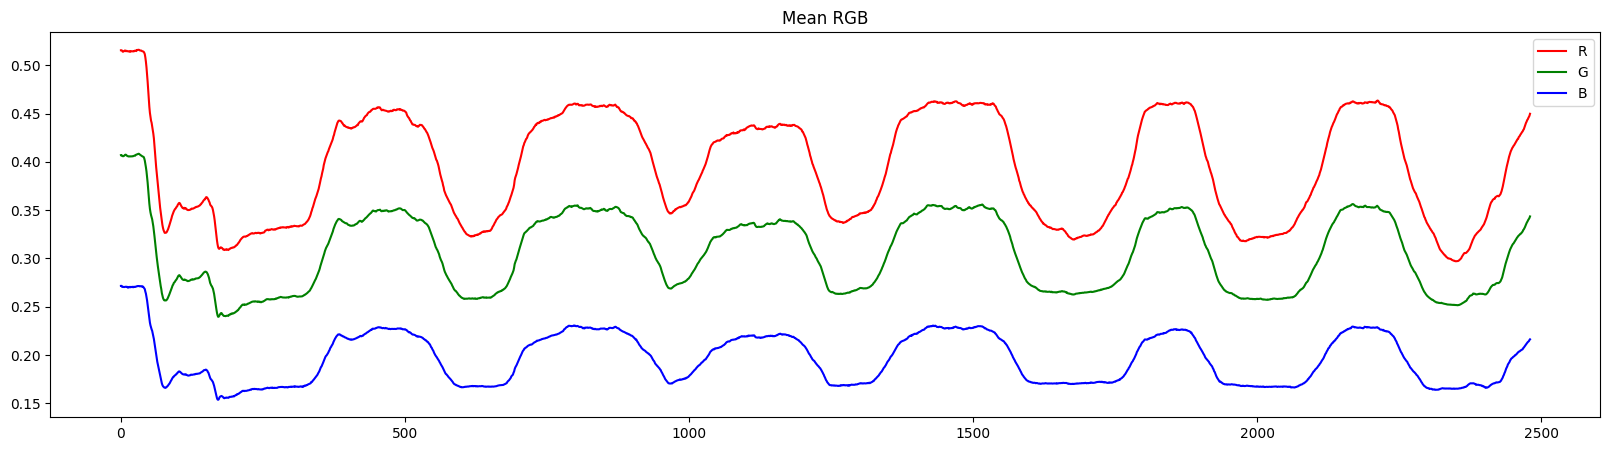

In [7]:
plt.figure(figsize=(20,5))
plt.plot(mean_rgb[:,0], label = 'R', color='red')
plt.plot(mean_rgb[:,1], label = 'G', color='green')
plt.plot(mean_rgb[:,2], label = 'B', color='blue')
plt.legend()
plt.title("Mean RGB")
plt.show()

POS

In [8]:
l = int(fps * 1.6)
print(f"Window length: {l}")
rPPG_signals = np.zeros(mean_rgb.shape[0])
print(f"rPPG_signals shape: {rPPG_signals.shape}")

Window length: 48
rPPG_signals shape: (2481,)


In [9]:
for t in range (0, mean_rgb.shape[0] - l):

    ## CREATE C DATA
    C = mean_rgb[t:t+l-1,:].T

    # print(f"C shape: {C.shape}")
    # print (f"C: \n{C}")

    ## CREATE TEMPORAL NORMALIZATION

    mean_color = np.mean(C, axis=1)

    # print(f"Shape of mean color: {mean_color.shape}")
    # print(f"Mean Color: {mean_color}")

    diag_mean_color = np.diag(mean_color)

    # print(f"Shape of diag mean color: {diag_mean_color.shape}")
    # print(f"Diag Mean Color: \n{diag_mean_color}")

    diag_mean_color_inv = np.linalg.inv(diag_mean_color)
    # print(f"Shape of diag mean color inv: {diag_mean_color_inv.shape}")
    # print(f"Diag Mean Color Inv: \n{diag_mean_color_inv}")

    Cn = np.matmul(diag_mean_color_inv, C)
    # print(f"Cn Shape: {Cn.shape}")



    ##FROM 3D TO 2D

    projection_matrix = np.array([[0, 1, -1], [-2, 1, 1]]) 

    S= np.matmul(projection_matrix, Cn)
    # print(f"Shape of S: {S.shape}")

    ##FROM 2D TO 1D

    std = np.array([1, np.std(S[0,:]) / np.std(S[1,:])])
    # print(f"Shape of std: {std.shape}")
    # print(f"std: {std}")

    P = np.matmul(std, S)
    # print(f"Shape of P: {P.shape}")

    # plt.figure(figsize=(20,5))
    # plt.plot(P)

    ## OVERLAPPING

    epsilon = 1e-8  # Small value to avoid division by zero
    rPPG_signals[t:t+l-1] = rPPG_signals[t:t+l-1] + (P - np.mean(P)) / (np.std(P) + epsilon)



    # break



GRGB

In [10]:
R = mean_rgb[:, 0]
G = mean_rgb[:, 1]
B = mean_rgb[:, 2]

GRGB_signal = (G/R) + (G/B)

# GRGB_signal.shape

Converting Timestamps

In [11]:
timestamps = []

for file_name in png_list:
    # Use regex to extract digits following 'Image' and before '.png'
    match = re.search(r'Image(\d+)\.png', file_name)
    if match:
        timestamps.append(match.group(1))

# print(len(timestamps))

formatted_times = []
for ts in timestamps:
    # Convert nanoseconds to seconds
    timestamp_sec = int(ts) / 1e9
    
    # Create a datetime object for the integer part of the timestamp
    time = dt.datetime.fromtimestamp(timestamp_sec)
    
    # Get the fractional seconds (2 decimal places)
    fractional_sec = f"{timestamp_sec % 60:.2f}"
    
    # Combine the minute and second part from the datetime object with fractional seconds
    formatted_time = time.strftime("%M:%S") + fractional_sec[2:]  # Skip leading '0' in fractional seconds
    formatted_times.append(formatted_time)

formatted_times = sorted(formatted_times)
# Print formatted times and original timestamps
# print(len(formatted_times))
# print(formatted_times[:5])
# print(timestamps[:5])

Shape of rPPG_signals: (2481,)


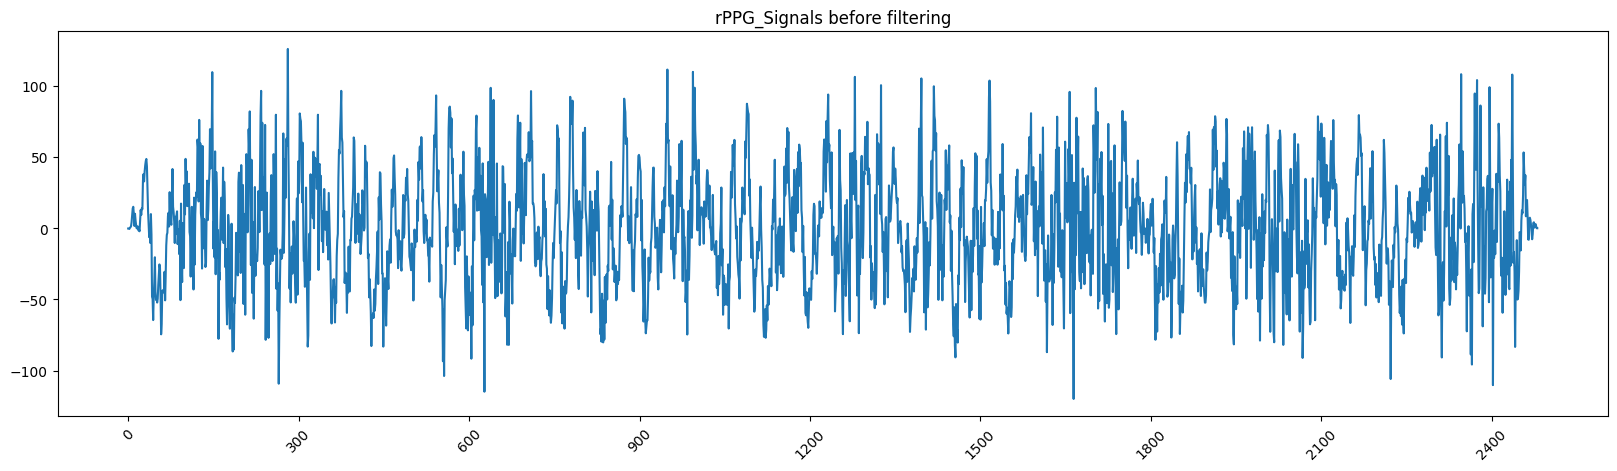

In [24]:
from matplotlib.ticker import MaxNLocator


print(f"Shape of rPPG_signals: {rPPG_signals.shape}")
plt.figure(figsize=(20,5))
# plt.plot(formatted_times, rPPG_signals)
plt.plot(rPPG_signals)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability

plt.title(f"rPPG_Signals before filtering")
plt.show()

Shape of GRGB_signals: (2481,)


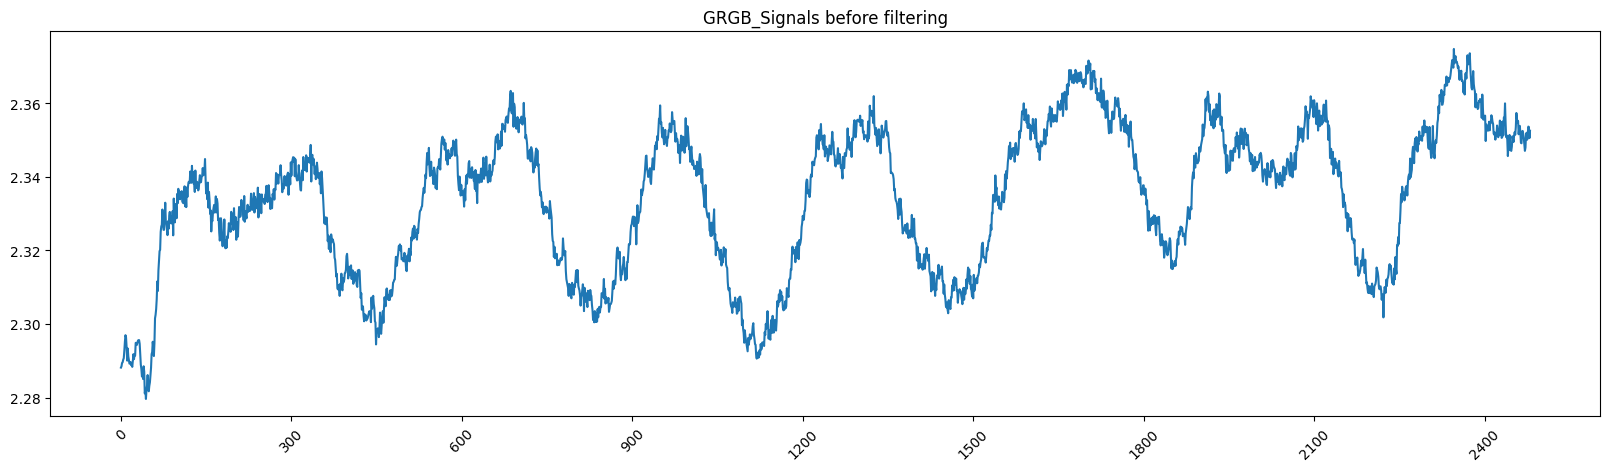

In [25]:
from matplotlib.ticker import MaxNLocator


print(f"Shape of GRGB_signals: {GRGB_signal.shape}")
plt.figure(figsize=(20,5))
# plt.plot(formatted_times, GRGB_signal)
plt.plot(GRGB_signal)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability

plt.title(f"GRGB_Signals before filtering")
plt.show()

Shape of rPPG_signals: (2481,)
[ 0.07727114  0.00228431 -0.05750716 ... -0.20112941 -0.21531719
 -0.22448309]


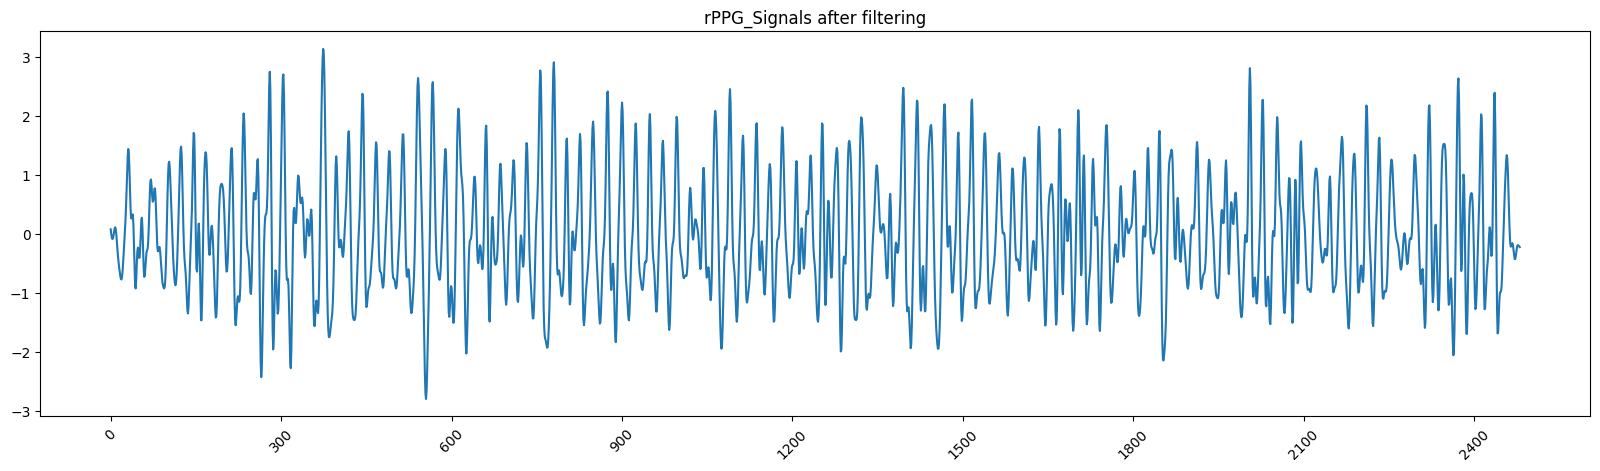

In [27]:
from scipy import signal

lowcut = 0.65
highcut = 4

b, a = signal.butter(6, [lowcut, highcut], btype='bandpass', fs=fps)
rPPG_filtered = signal.filtfilt(b, a, rPPG_signals)

#standardization
rPPG_filtered = (rPPG_filtered-np.mean(rPPG_filtered))/np.std(rPPG_filtered)

print(f"Shape of rPPG_signals: {rPPG_filtered.shape}")
print(rPPG_filtered)
plt.figure(figsize=(20,5))
# plt.plot(formatted_times, rPPG_filtered)
plt.plot(rPPG_filtered)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.title(f"rPPG_Signals after filtering")
plt.show()

Shape of GRGB_signals: (2481,)
[ 0.09362756 -0.10605049 -0.19984715 ... -0.16231064 -0.25397661
 -0.37569425]


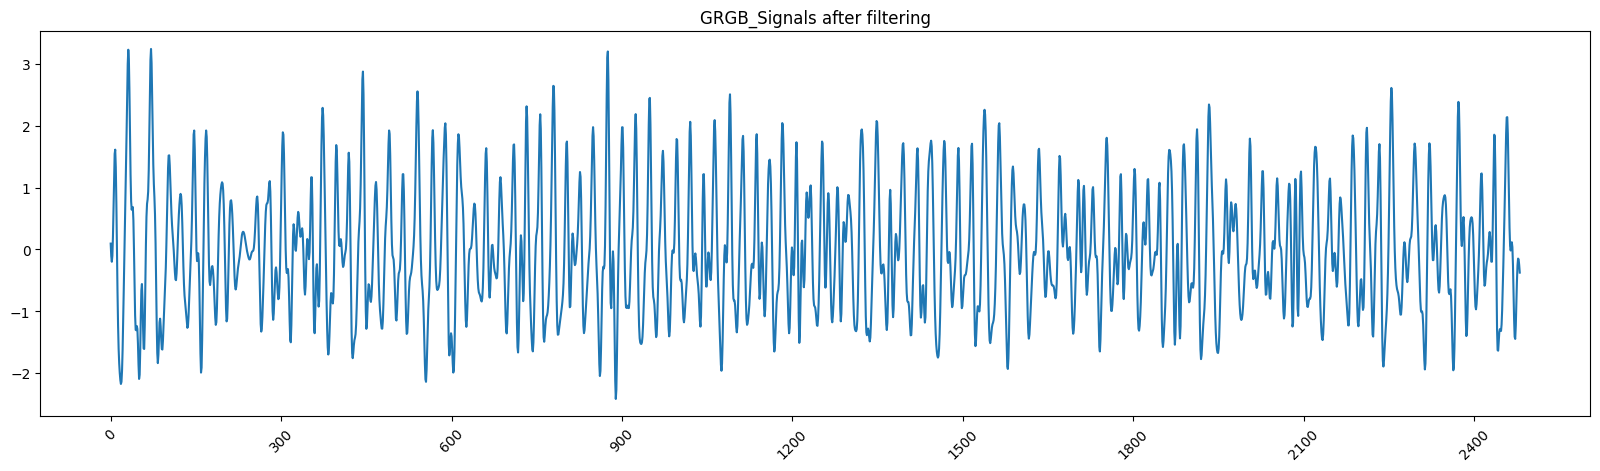

In [28]:
from scipy import signal

lowcut = 0.65
highcut = 4

b, a = signal.butter(6, [lowcut, highcut], btype='bandpass', fs=fps)
GRGB_filtered = signal.filtfilt(b, a, GRGB_signal)

#standardization
GRGB_filtered = (GRGB_filtered-np.mean(GRGB_filtered))/np.std(GRGB_filtered)

print(f"Shape of GRGB_signals: {GRGB_filtered.shape}")
print(GRGB_filtered)
plt.figure(figsize=(20,5))
# plt.plot(formatted_times, GRGB_filtered)
plt.plot(GRGB_filtered)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.title(f"GRGB_Signals after filtering")
plt.show()

Compare with groundtruth

[1392644410889180000, 1392644410921138000, 1392644410937603000, 1392644410953130000, 1392644410969130000]


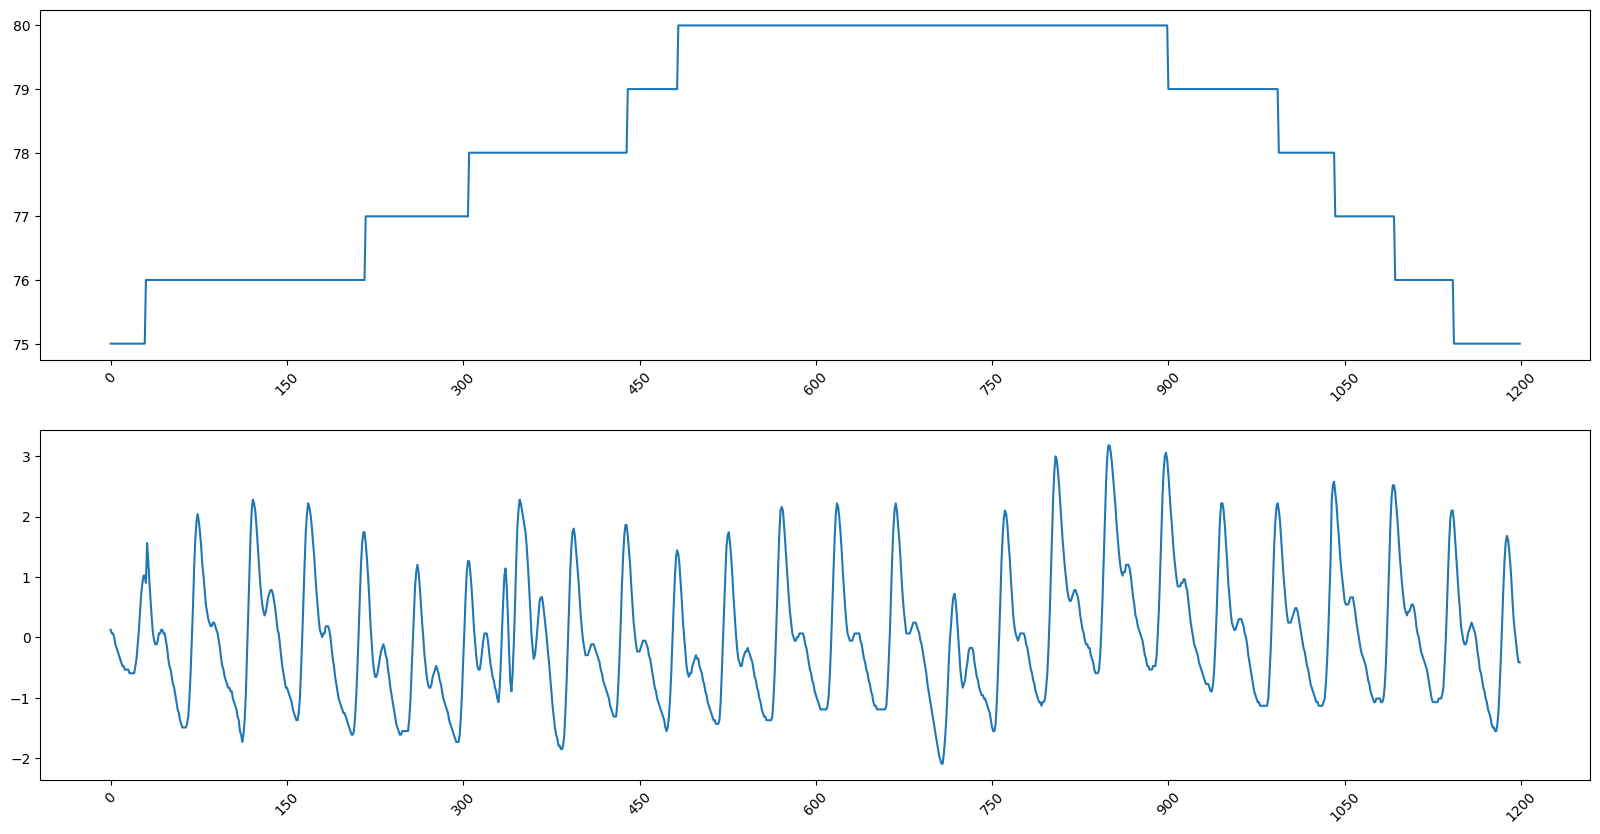

BPM = 77.00811194483877


In [16]:
import json 

gt_path = dataset_path + subject_name +'/01-03.json'

with open (gt_path, 'r') as file:
    data = json.load(file)

full_package_data = data["/FullPackage"]
image_data = data["/Image"]

timestamps_package = [entry["Timestamp"] for entry in full_package_data]
waveform = [entry["Value"]["waveform"] for entry in full_package_data]
pulseRate = [entry["Value"]["pulseRate"] for entry in full_package_data]
frame_package = [entry["FrameID"] for entry in full_package_data]
waveform = (waveform-np.mean(waveform))/np.std(waveform)

print(timestamps_package[:5])

## Converting Timestamps
# formatted_times_package = []
# for ts in timestamps_package:
#     # Convert nanoseconds to seconds
#     timestamp_sec = int(ts) / 1e9
    
#     # Create a datetime object for the integer part of the timestamp
#     time = dt.datetime.fromtimestamp(timestamp_sec)
    
#     # Get the fractional seconds (2 decimal places)
#     fractional_sec = f"{timestamp_sec % 60:.2f}"
    
#     # Combine the minute and second part from the datetime object with fractional seconds
#     formatted_time = time.strftime("%M:%S") + fractional_sec[2:]  # Skip leading '0' in fractional seconds
#     formatted_times_package.append(formatted_time)

# formatted_times_package = sorted(formatted_times_package)




# print(formatted_times_package[:5])
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(pulseRate[:1200])
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability

plt.subplot(2,1,2)
plt.plot(waveform[:1200])
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set the number of x-ticks to 10
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

##plotting against converted timestamps
# # Plot pulse rate
# plt.subplot(2, 1, 1)
# plt.plot(filtered_times, filtered_pulseRate)
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set number of x-ticks to 10
# plt.xticks(rotation=45)  # Rotate labels for better readability
# plt.title("Pulse Rate")

# # Plot waveform
# plt.subplot(2, 1, 2)
# plt.plot(filtered_times, filtered_waveform)
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))  # Set number of x-ticks to 10
# plt.xticks(rotation=45)  # Rotate labels for better readability
# plt.title("Waveform")
# plt.show()

print(f"BPM = {np.mean(pulseRate)}")
# print(len(timestamps_package))
# print(len(frame_package))
# print(len(timestamps))
# print(len(frame))

In [17]:
# print(formatted_times[:5])
# print(formatted_times_package[:5])
print(timestamps[:5])
print(timestamps_package[:5])

['1392644410909562000', '1392644410942906000', '1392644410976220000', '1392644411009565000', '1392644411042909000']
[1392644410889180000, 1392644410921138000, 1392644410937603000, 1392644410953130000, 1392644410969130000]


Estimate BPM

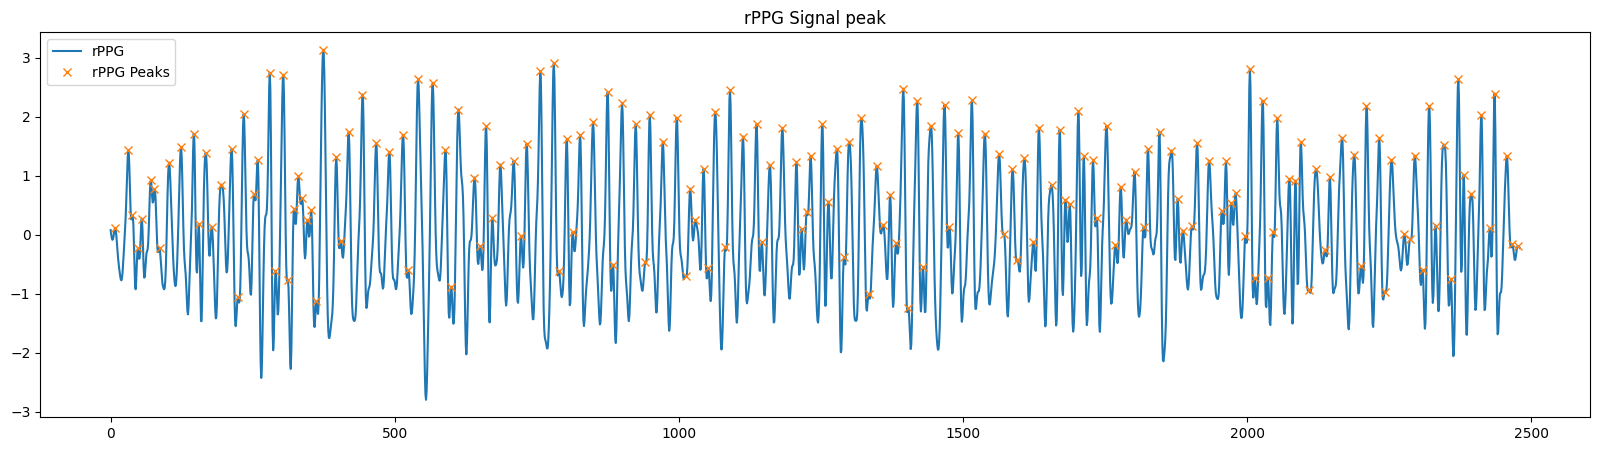

rPPG Peaks = 176


In [18]:
from scipy.signal import find_peaks
rPPG_peaks, _ = find_peaks(rPPG_filtered)

plt.figure(figsize=(20,5))
plt.plot(rPPG_filtered, label='rPPG')
plt.plot(rPPG_peaks, rPPG_filtered[rPPG_peaks], "x", label='rPPG Peaks')
plt.legend()
plt.title("rPPG Signal peak")
plt.show()

print(f"rPPG Peaks = {len(rPPG_peaks)}")

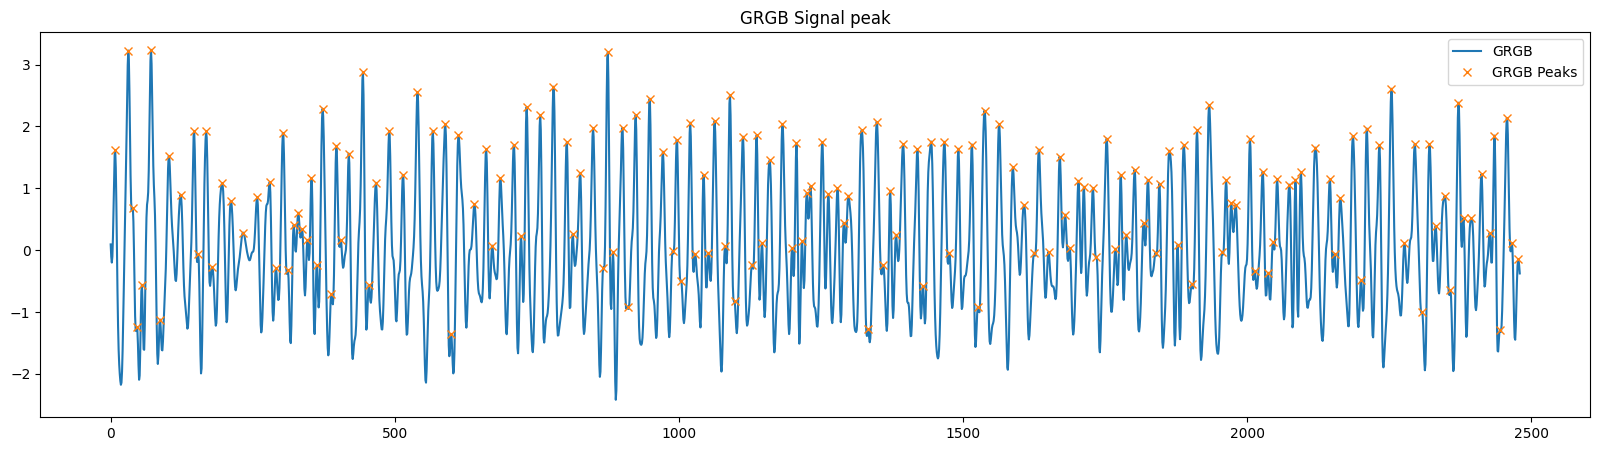

GRGB Peaks = 173


In [19]:
from scipy.signal import find_peaks
GRGB_peaks, _ = find_peaks(GRGB_filtered)

plt.figure(figsize=(20,5))
plt.plot(GRGB_filtered, label='GRGB')
plt.plot(GRGB_peaks, GRGB_filtered[GRGB_peaks], "x", label='GRGB Peaks')
plt.legend()
plt.title("GRGB Signal peak")
plt.show()

print(f"GRGB Peaks = {len(GRGB_peaks)}")

C:\Users\Darren\AppData\Roaming\Python\Python311\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 4932 is greater than input length  = 4931, using nperseg = 4931
  warnings.warn('nperseg = {0:d} is greater than input length '


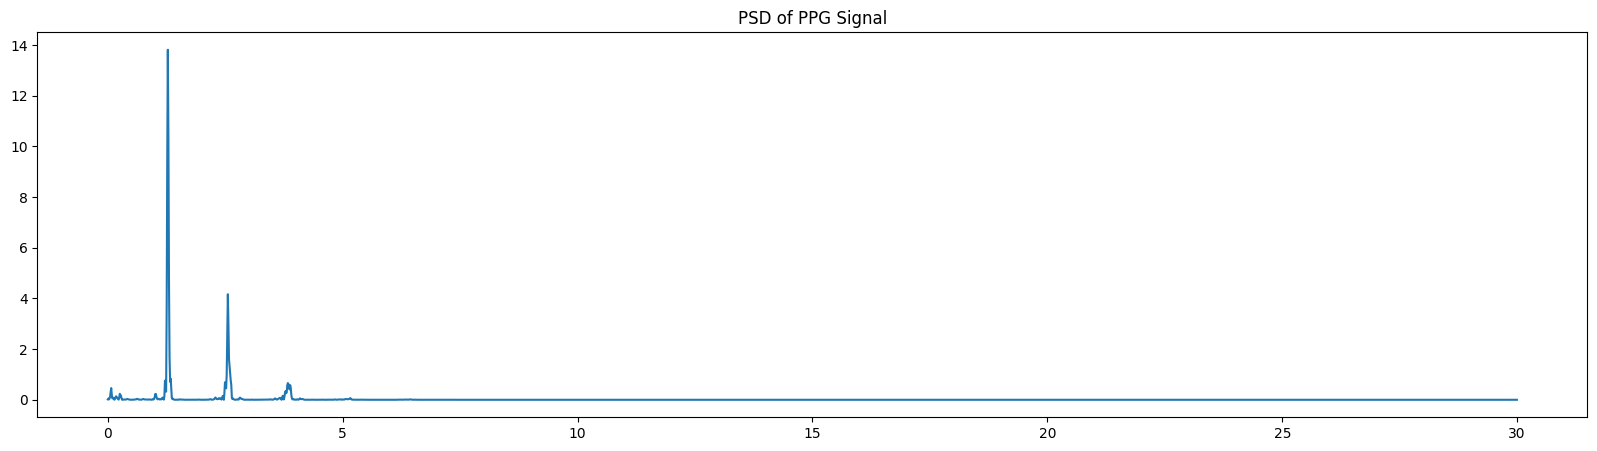

Max Frequency of PPG Signal: 1.2776313121070777
BPM: 76.65787872642466


In [20]:
from scipy.signal import welch

seg_len = (2*waveform.shape[0]) // n_segment + 1

freq_PPG, psd_PPG = welch(waveform, fs=60, nperseg=seg_len, window='flattop')

plt.figure(figsize=(20,5))
plt.plot(freq_PPG, psd_PPG)
plt.title("PSD of PPG Signal")
plt.show()

max_freq_PPG =  freq_PPG[np.argmax(psd_PPG)]
print(f"Max Frequency of PPG Signal: {max_freq_PPG}")
rPPG_bpm = max_freq_PPG * 60
print(f"BPM: {rPPG_bpm}")

C:\Users\Darren\AppData\Roaming\Python\Python311\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 2482 is greater than input length  = 2481, using nperseg = 2481
  warnings.warn('nperseg = {0:d} is greater than input length '


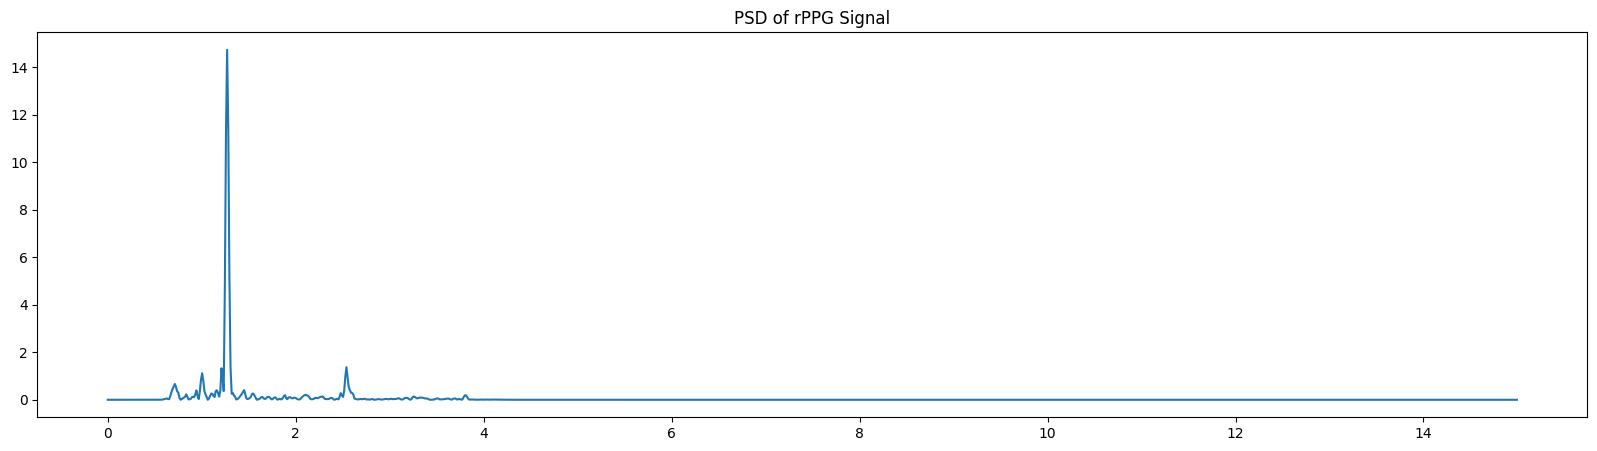

Max Frequency of rPPG Signal: 1.2696493349455864
BPM: 76.17896009673518


In [21]:
from scipy.signal import welch

seg_len = (2*rPPG_filtered.shape[0]) // n_segment + 1

freq_rPPG, psd_rPPG = welch(rPPG_filtered, fs=fps, nperseg=seg_len, window='flattop')

plt.figure(figsize=(20,5))
plt.plot(freq_rPPG, psd_rPPG)
plt.title("PSD of rPPG Signal")
plt.show()

max_freq_rPPG =  freq_rPPG[np.argmax(psd_rPPG)]
print(f"Max Frequency of rPPG Signal: {max_freq_rPPG}")
rPPG_bpm = max_freq_rPPG * 60
print(f"BPM: {rPPG_bpm}")

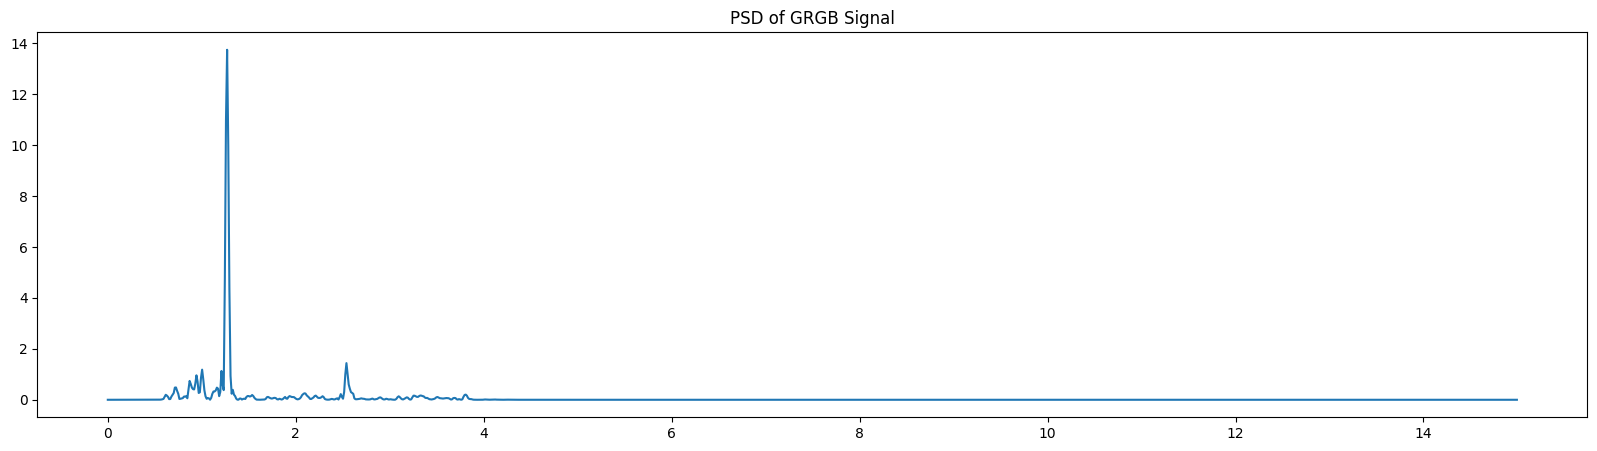

Max Frequency of GRGB Signal: 1.2696493349455864
BPM: 76.17896009673518


In [22]:
from scipy.signal import welch

seg_len = (2*GRGB_filtered.shape[0]) // n_segment + 1

freq_GRGB, psd_GRGB = welch(GRGB_filtered, fs=fps, nperseg=seg_len, window='flattop')

plt.figure(figsize=(20,5))
plt.plot(freq_GRGB, psd_GRGB)
plt.title("PSD of GRGB Signal")
plt.show()

max_freq_GRGB =  freq_GRGB[np.argmax(psd_GRGB)]
print(f"Max Frequency of GRGB Signal: {max_freq_GRGB}")
GRGB_bpm = max_freq_GRGB * 60
print(f"BPM: {GRGB_bpm}")

BPM 76.17896009673518 Hz


<function matplotlib.pyplot.show(close=None, block=None)>

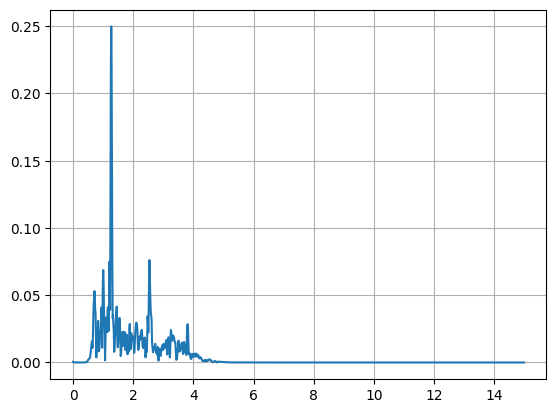

In [23]:
from scipy.fft import fft, fftfreq
from scipy.signal import windows

N = len(rPPG_filtered)
T = 1/fps
x = np.linspace(0.0, N*T, N, endpoint=False)

window = windows.flattop(N)
rPPG_windowed = rPPG_filtered * window



yf = fft(rPPG_windowed)
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))

max_freq_idx = np.argmax(2.0/N * np.abs(yf[0:N//2]))  # Index of max amplitude
max_freq_rPPG = xf[max_freq_idx]  # Corresponding frequency

# Print the max frequency
print(f"BPM {max_freq_rPPG*60} Hz")
plt.grid()

# print(f"Max Frequency of rPPG Signal: {max_freq_rPPG}")
plt.show